In [154]:
%matplotlib inline
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import pandas as pd
import geopandas as gpd
import contextily as ctx

import numpy as np
import PIL.Image
import time
import functools

import tensorflow as tf

In [155]:
# GeoPandas comes with some data that we can quickly load in
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [156]:
# Check the coordinate reference system (crs)
# It come in an epsg code, 4326 is WGS84 - World Geodetic System 1984, used in GPS
world.crs

{'init': 'epsg:4326'}

In [157]:
# Geographic data has a spatial component (held in the geometry column) and a tabular component
# Check out the first few rows of the tabular component
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


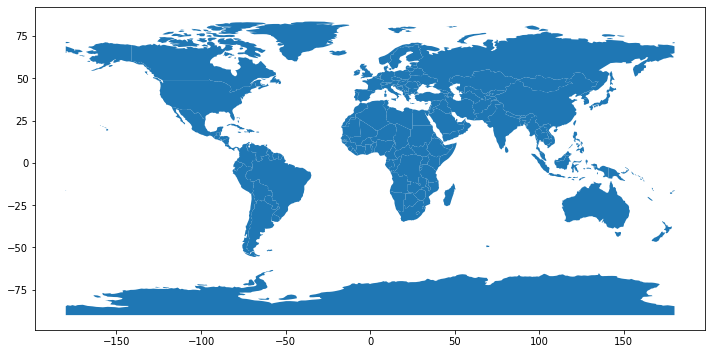

In [158]:
 # Plot your map with default look and feel
world.plot()

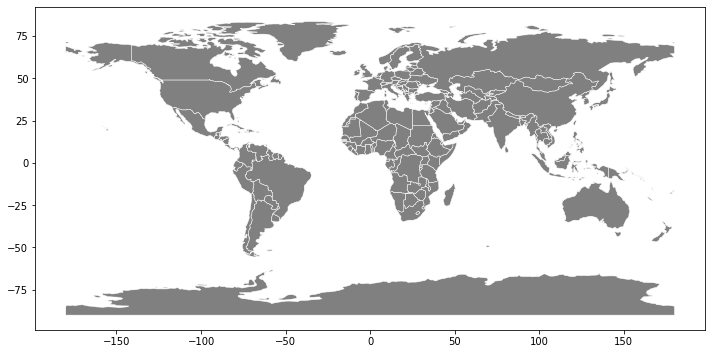

In [159]:
 # Plot your map, with customizations
world.plot(color='grey', linewidth=0.5, edgecolor='white', figsize=(12,10))

In [160]:
# We'll need to load in some local data
import os
data_pth = "../Data/" 

In [161]:
# Load in Eclipse data
eclipses = gpd.read_file(os.path.join(data_pth, "Eclipses.shp"))

In [162]:
# Check the coorindate reference system
eclipses.crs

{'init': 'epsg:4326'}

In [163]:
eclipses.head()

,Year,geometry
0,2017,"POLYGON Z ((-171.577 39.738 0.000, -171.740 39..."
1,2019,"POLYGON Z ((-160.398 -37.648 0.000, -160.654 -..."
2,2020,"POLYGON Z ((-132.816 -7.774 0.000, -132.743 -7..."
3,2021,"POLYGON Z ((-51.183 -53.087 0.000, -48.952 -51..."
4,2023,"POLYGON Z ((180.000 3.217 0.000, 180.000 3.123..."


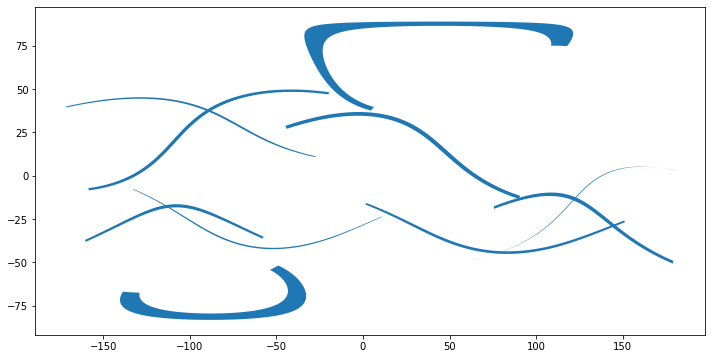

In [164]:
# And let's plot with the default style
eclipses.plot()

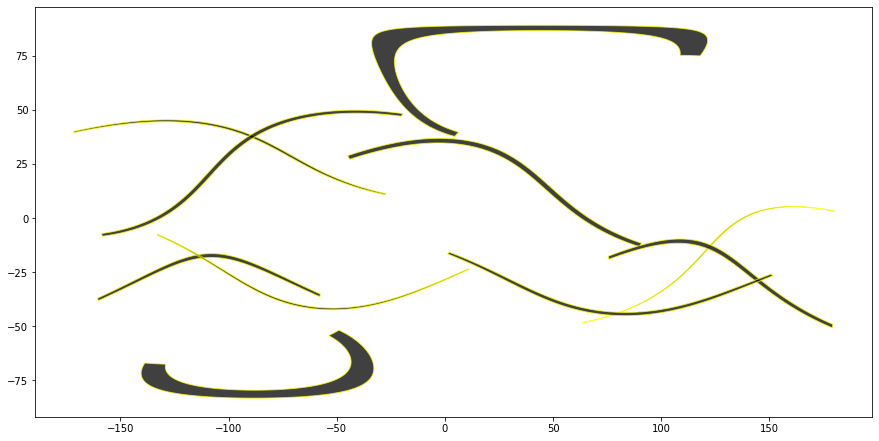

In [165]:
# And let's plot with a customized style
eclipses.plot(figsize=(15,10), color='black', edgecolor='yellow', alpha=0.75)

In [166]:
# We now want to plot both datasets together. First verify that they have the same crs
world.crs == eclipses.crs

True

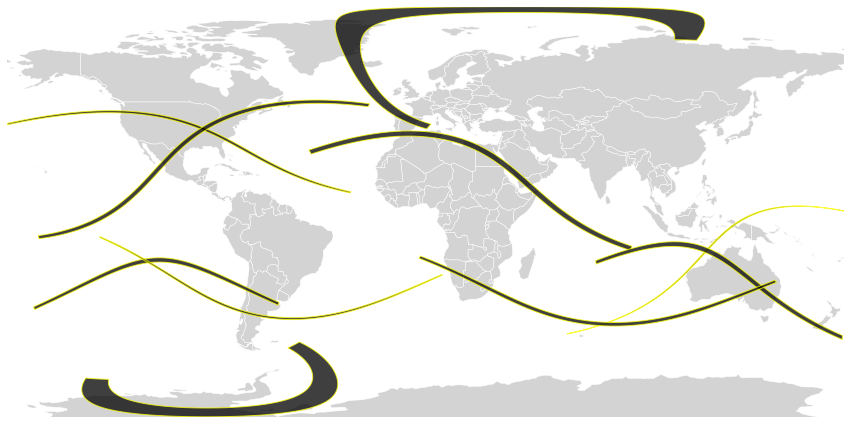

In [167]:
# Let's plot the eclipses on top of our world data
base = world.plot(color='lightgrey', linewidth=0.5, edgecolor='white', figsize=(15,10))
eclipses.plot(ax=base, color='black', edgecolor='yellow', alpha=0.75)
base.set_axis_off()

minx, miny, maxx, maxy = eclipses.total_bounds
base.set_xlim(minx, maxx)
base.set_ylim(miny, maxy)

plt.savefig('..//data//eclipsemap.png', bbox_inches='tight',dpi=300)

## Now let's do some style transfer with TensorFlow

In [168]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [169]:
content_path = '..//data//eclipsemap.png'
#style_path = '..//data//burlap-sac.jpg'
#style_path = '..//data//totality.jpg'
#style_path = '..//data//moon_shadows.jpg'
style_path = '..//data//Fenetre_art_moderne_Firenze_by_gelinh.jpg'

In [170]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [171]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

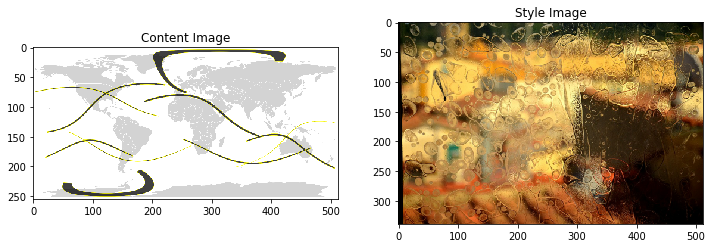

In [172]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [173]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')

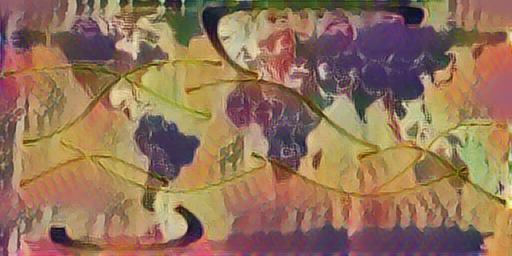

In [174]:
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [175]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [176]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('hook', 0.43929267),
 ('fire_screen', 0.05812352),
 ('paper_towel', 0.03865259),
 ('stethoscope', 0.03671392),
 ('stretcher', 0.036209363)]

In [177]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_18
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [178]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [179]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [180]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 339, 512, 64)
  min:  0.0
  max:  763.1325
  mean:  30.608519

block2_conv1
  shape:  (1, 169, 256, 128)
  min:  0.0
  max:  3270.204
  mean:  140.89551

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  7079.513
  mean:  139.98233

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  16013.244
  mean:  563.5114

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  2644.747
  mean:  43.27451



In [181]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [182]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [183]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  171529.75
    mean:  736.11096

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  200469.27
    mean:  25780.484

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  499435.5
    mean:  29690.578

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  11380757.0
    mean:  299612.75

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  98248.58
    mean:  1582.1122

Contents:
   block5_conv2
    shape:  (1, 15, 32, 512)
    min:  0.0
    max:  873.114
    mean:  14.735149


In [184]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [185]:
image = tf.Variable(content_image)

In [186]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [187]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [188]:
style_weight=1e-2
content_weight=1e4

In [189]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [190]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

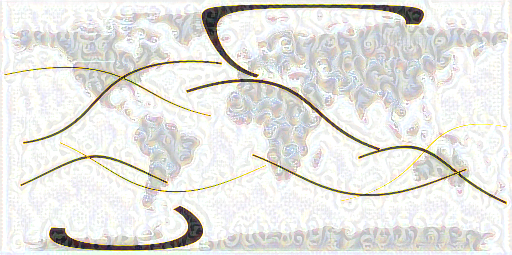

In [191]:
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)